# Visualización 1

En esta clase vamos a usar herramientas de visualización para hacer análisis exploratorio de datos sobre un dataset de corredores de una maratón.

El objetivo de la clase es que repasemos los principales tipos de gráficos que vamos a usar de la biblioteca seaborn, y que les van a servir para el análisis exploratorio que van a hacer en su TP1.

https://seaborn.pydata.org/index.html


## Dataset

En esta clase analizaremos un dataset que contiene información de los resultados de una maratón. La información está desagregada para cada corredor.

Los campos que contiene son:
1. age
2. gender
3. split: tiempo que tardó en correr la primera mitad de la maratón
4. final: tiempo que tardó en correr la maratón completa

### Ejercicio 1 - Importar 
Importar el archivo marathon.csv e inspeccionar los primeros casos y los tipos de datos.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data_location = "../Data/marathon.csv"
data = pd.read_csv(data_location)
data.head()

,age,gender,split,final
0,33,M,01:05:38,02:08:51
1,32,M,01:06:26,02:09:28
2,31,M,01:06:49,02:10:42
3,38,M,01:06:16,02:13:45
4,31,M,01:06:32,02:13:59


In [3]:
data.dtypes

age        int64
gender    object
split     object
final     object
dtype: object

### Ejercicio 2 - Trabajar con fechas

#### Ejercicio 2a: 

Queremos convertir ahora los datos de las columnas split y final en tipo `TimeDelta`

https://pandas.pydata.org/pandas-docs/stable/user_guide/timedeltas.html

Un objeto de tipo `TimeDelta` representa una duración de tiempo, es decir la diferencia de tiempo que hay entre dos fechas o tiempos.

Ejemplos de TimeDelta son

```
# un día:
pd.Timedelta(1, unit='d')

# un día con 1 segundo:
pd.Timedelta(days=1, seconds=1)

# un día con 1 hora y un segundo:
pd.Timedelta(days=1, hours = 1, seconds=1)

```

Para eso vamos a definir la función `convert_time` que recibe un `string` y devuelve una instancia de `TimeDelta`

Y usando `apply` vamos a convertir en `TimeDelta` cada valor de las columnas split y final

Vamos a guardar el resultado de convertir estas columnas en las columnas split_timedelta y final_timedelta

Como último paso veamos de qué tipo son las columnas nuevas del `DataFrame`



In [4]:
def convert_time(s):
        parts = s.split(':')
        if len(parts) == 3:
            horas = int(parts[0])
            minutos = int(parts[1])
            segundos = int(parts[2])
            result = pd.Timedelta(hours=horas, minutes=minutos, seconds=segundos)
        else:
            # creo un Timedelta de cero:
            result = pd.Timedelta(hours=0, minutes=0, seconds=0)
        return result    

In [5]:
data['split_timedelta'] = data['split'].apply(convert_time)
# veo qué hizo:
data['split_timedelta'].head(4)

0   01:05:38
1   01:06:26
2   01:06:49
3   01:06:16
Name: split_timedelta, dtype: timedelta64[ns]

In [6]:
data['final_timedelta'] = data['final'].apply(convert_time)
# veo qué hizo:
data['final_timedelta'].head(4)

0   02:08:51
1   02:09:28
2   02:10:42
3   02:13:45
Name: final_timedelta, dtype: timedelta64[ns]

In [7]:
data.dtypes

age                          int64
gender                      object
split                       object
final                       object
split_timedelta    timedelta64[ns]
final_timedelta    timedelta64[ns]
dtype: object

#### Ejercicio 2b: 

Al castear instancias de `TimeDelta` a `int` obtenemos un valor expresado en nanosegundos, la mínima unidad que se encuentra representada en un timedelta.

1 nano = 10 ^ (-9), es decir 0.000000001 (ocho ceros después del punto decimal y un 1 en el noveno lugar)

Ahora queremos crear columnas con los tiempos de split y final expresados en segundos.

Vamos a llamar a esas nuevas columnas split_sec y final_sec

In [8]:
data['split_sec'] = data['split_timedelta'].astype(np.int64) / 1E9
data['final_sec'] = data['final_timedelta'].astype(np.int64) / 1E9
data.head()

,age,gender,split,final,split_timedelta,final_timedelta,split_sec,final_sec
0,33,M,01:05:38,02:08:51,01:05:38,02:08:51,3938.0,7731.0
1,32,M,01:06:26,02:09:28,01:06:26,02:09:28,3986.0,7768.0
2,31,M,01:06:49,02:10:42,01:06:49,02:10:42,4009.0,7842.0
3,38,M,01:06:16,02:13:45,01:06:16,02:13:45,3976.0,8025.0
4,31,M,01:06:32,02:13:59,01:06:32,02:13:59,3992.0,8039.0


### Ejercicio 3 - Graficar

Veamos la relación entre split_sec y final_sec con un jointplot

Documentación:
https://seaborn.pydata.org/generated/seaborn.jointplot.html

La idea es que generemos un gráfico de tipo 'hex' como los de ejemplo de la documentación.


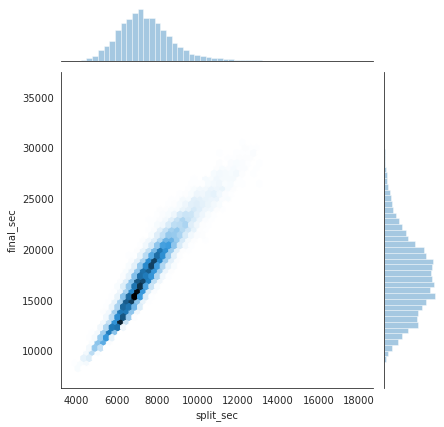

In [9]:
%matplotlib inline
with sns.axes_style('white'):
    g = sns.jointplot("split_sec", "final_sec", data, kind='hex')
    #g.ax_joint.plot(np.linspace(4000, 16000), np.linspace(8000, 32000), ':k');

### Ejercicio 4 - Caracterizar corredores

#### Ejercicio 4a:

Los corredores se dividen en dos: los que corren más rápido la primera mitad que la segunda y viceversa. 

Creamos una nueva columna para visualizar esta relación:

`data['split_frac'] = 1 - 2 * data['split_sec'] / data['final_sec']`

* Si **data['split_sec'] es menor que la mitad de data['final_sec']**, entonces el corredor corre más rápido la primera mitad de la carrera y data['split_frac'] es mayor que cero.

* Si **data['split_sec'] es mayor que la mitad de data['final_sec']**, entonces el corredor corre más lento la primera mitad de la carrera y data['split_frac'] es menor que cero.

* Si **data['split_sec'] es igual a la mitad de data['final_sec']**, entonces el corredor corre con igual velocidad la primera y la segunda mitad de la carrera y data['split_frac'] es cero.


Visualicemos la distribución de esta nueva variable, usando `distplot` y dibujando una línea en el eje vertical que separe los valores menores y mayores que cero.

Documentación:
https://seaborn.pydata.org/generated/seaborn.distplot.html


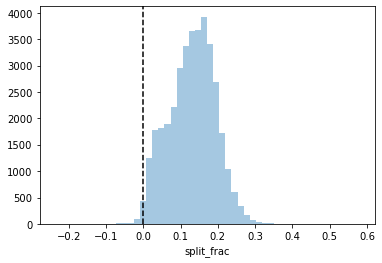

In [10]:
data['split_frac'] = 1 - 2 * data['split_sec'] / data['final_sec']
sns.distplot(data['split_frac'], kde=False);
plt.axvline(0, color="k", linestyle="--");

#### Ejercicio 4b:

¿Cuántos corredores fueron más lento en la primera mitad?

In [11]:
sum(data.split_frac < 0)

251

#### Ejercicio 4c:
Veamos ahora si existe alguna correlación entre los valores de las columnas 'age', 'split_sec', 'final_sec', 'split_frac'

Para eso vamos a usar `PairGrid`

https://seaborn.pydata.org/generated/seaborn.PairGrid.html

¿Qué conclusiones podemos sacar de estos gráficos?

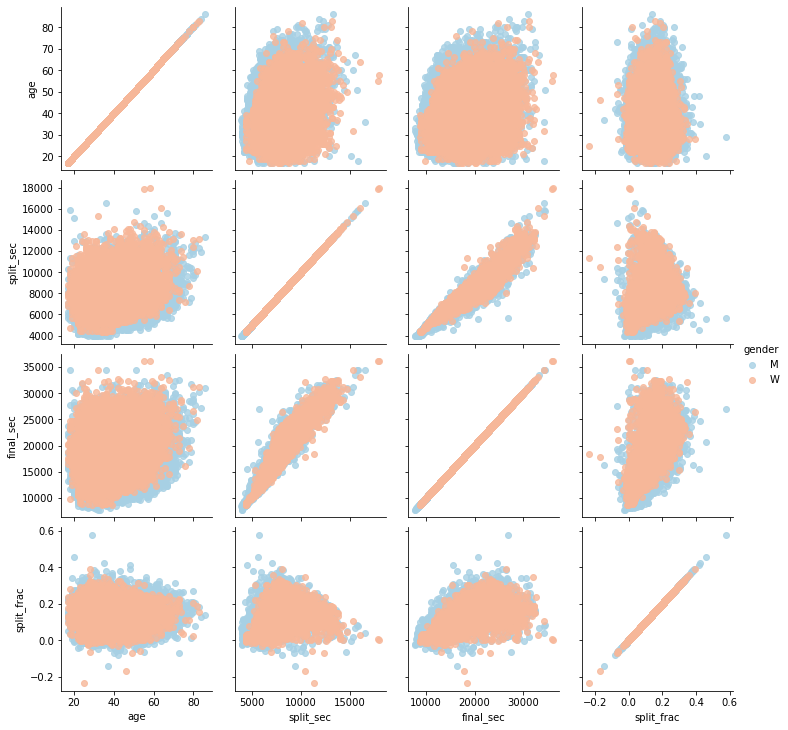

In [12]:
g = sns.PairGrid(data, vars=['age', 'split_sec', 'final_sec', 'split_frac'],
                 hue='gender', palette='RdBu_r')
g.map(plt.scatter, alpha=0.8)
g.add_legend();

#### Ejercicio 4d:

Veamos ahora superpuestas las distribuciones de los valores de la columna split_frac para hombres y mujeres.

Usemos para esto `kdeplot`
https://seaborn.pydata.org/generated/seaborn.kdeplot.html


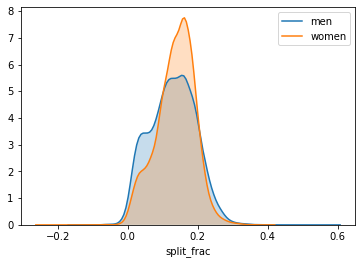

In [13]:
data_men = data.split_frac[data.gender=='M']
data_women = data.split_frac[data.gender=='W']
sns.kdeplot(data_men, label='men', shade=True)
sns.kdeplot(data_women, label='women', shade=True)
plt.xlabel('split_frac');

#### Ejercicio 4e:

Comparemos ambas distribuciones usando un boxplot y un violinplot

https://seaborn.pydata.org/generated/seaborn.boxplot.html

https://seaborn.pydata.org/generated/seaborn.violinplot.html

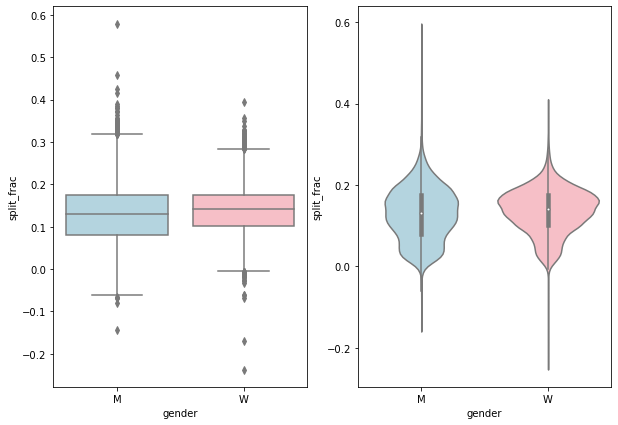

In [14]:
fig, axs = plt.subplots(ncols=2, figsize=(10,7))

sns.boxplot("gender", "split_frac", data=data,
               palette=["lightblue", "lightpink"], ax=axs[0])
sns.violinplot("gender", "split_frac", data=data,
               palette=["lightblue", "lightpink"], ax=axs[1]);

#### Ejercicio 4f:

Generemos violinplots para la distribución de valores del campo edad.

Comencemos creando una nueva columna (age_dec) que especifique la década de edad de cada corredor (aquellos que están en "los '30", en "los '40", ...) y grafiquemos la distribución de los valores de age_dec

https://seaborn.pydata.org/generated/seaborn.violinplot.html

In [15]:
data['age_dec'] = data.age.apply(lambda age: 10 * (age // 10))
data.head()

,age,gender,split,final,split_timedelta,final_timedelta,split_sec,final_sec,split_frac,age_dec
0,33,M,01:05:38,02:08:51,01:05:38,02:08:51,3938.0,7731.0,-0.018756,30
1,32,M,01:06:26,02:09:28,01:06:26,02:09:28,3986.0,7768.0,-0.026262,30
2,31,M,01:06:49,02:10:42,01:06:49,02:10:42,4009.0,7842.0,-0.022443,30
3,38,M,01:06:16,02:13:45,01:06:16,02:13:45,3976.0,8025.0,0.009097,30
4,31,M,01:06:32,02:13:59,01:06:32,02:13:59,3992.0,8039.0,0.006842,30


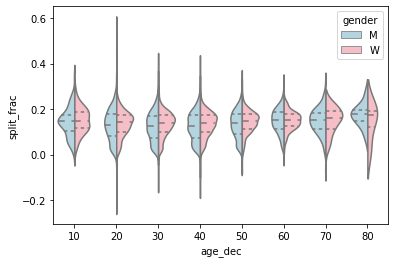

In [16]:
sns.violinplot("age_dec", "split_frac", hue="gender", data=data,
                   split=True, inner="quartile",
                   palette=["lightblue", "lightpink"]);

#### Ejercicio 4g:

¿Hay correlación entre los valores de "split_frac" y el hecho de haber terminado más rápido la carrera (valores más chicos de final_sec)? 

Analicemos esta pregunta usando `lmplot`

https://seaborn.pydata.org/generated/seaborn.lmplot.html

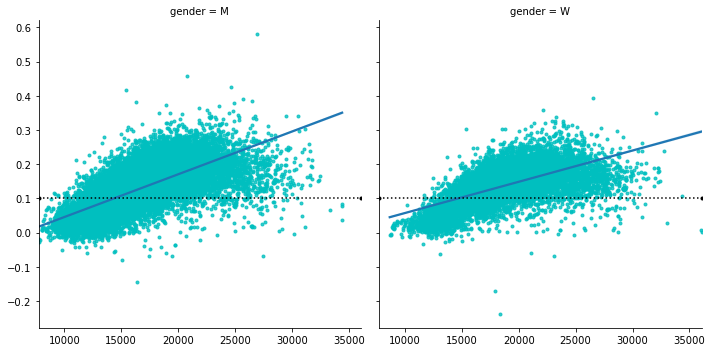

In [17]:
g = sns.lmplot('final_sec', 'split_frac', col='gender', data=data,
               markers=".", scatter_kws=dict(color='c'))
g.map(plt.axhline, y=0.1, color="k", ls=":");